In [1]:
import os
import random
import warnings

# Dataframe
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error

import optuna
from optuna import Trial
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings('ignore')

/home/yeeun/anaconda3/envs/tsf-spi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
start_date = '2010-01-01'
end_date = '2022-12-31'

In [3]:
data = pd.read_csv('./data/kospi.csv').dropna()
data = data[data['Date'] <= end_date]
data['Change'] = data['Kospi'].pct_change() * 100
data.loc[0, 'Change'] = 0
data

Date        Kospi      USD/KRW      GDP   IAIP    LIR         M1  \
0     2010-01-04  1696.140015  1132.400024  1143.67   79.3  5.350   59.71815   
1     2010-01-05  1690.619995  1141.300049  1143.67   79.3  5.350   59.71815   
2     2010-01-06  1705.319946  1130.400024  1143.67   79.3  5.350   59.71815   
3     2010-01-07  1683.449951  1134.900024  1143.67   79.3  5.350   59.71815   
4     2010-01-08  1695.260010  1123.099976  1143.67   79.3  5.350   59.71815   
...          ...          ...          ...      ...    ...    ...        ...   
3198  2022-12-23  2313.689941  1290.199951  1673.92  126.0  3.541  193.79220   
3199  2022-12-26  2317.139893  1279.239990  1673.92  126.0  3.541  193.79220   
3200  2022-12-27  2332.790039  1275.130005  1673.92  126.0  3.541  193.79220   
3201  2022-12-28  2280.449951  1272.280029  1673.92  126.0  3.541  193.79220   
3202  2022-12-29  2236.399902  1274.319946  1673.92  126.0  3.541  193.79220   

      disease    Change  
0           0  0.000000  
1           0 -0.325446  
2           0  0.869501  
3           0 -1.282457  
4           0  0.701539  
...       ...       ...  
3198        0 -1.826261  
3199        0  0.149110  
3200        0  0.675408  
3201        0 -2.243669  
3202        0 -1.931638  

[3203 rows x 9 columns]

In [4]:
split_date = '2021-12-31'

# train, valid, test 데이터 나누기
train_data = data.loc[data['Date'] <= split_date].copy()
test_data = data.loc[data['Date'] > split_date].copy()

In [5]:
print("Train 데이터 크기:", len(train_data))
print("Test 데이터 크기:", len(test_data))

Train 데이터 크기: 2959
Test 데이터 크기: 244


In [6]:
data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

train_data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
train_data['ds'] = pd.to_datetime(train_data['ds'])

test_data.rename(columns={'Date': 'ds', 'Change': 'y'}, inplace=True)
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [7]:
regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

# 가능한 모든 조합의 리스트 생성
all_combinations = []
for r in range(1, len(regressor_columns) + 1):
    all_combinations.extend(combinations(regressor_columns, r))

regressor_combinations = ['_'.join(combination) for combination in all_combinations]

In [8]:
train_data.iloc[:, :2]

ds        Kospi
0    2010-01-04  1696.140015
1    2010-01-05  1690.619995
2    2010-01-06  1705.319946
3    2010-01-07  1683.449951
4    2010-01-08  1695.260010
...         ...          ...
2954 2021-12-24  3012.429932
2955 2021-12-27  2999.550049
2956 2021-12-28  3020.239990
2957 2021-12-29  2993.290039
2958 2021-12-30  2977.649902

[2959 rows x 2 columns]

02:41:06 - cmdstanpy - INFO - Chain [1] start processing
02:41:06 - cmdstanpy - INFO - Chain [1] done processing


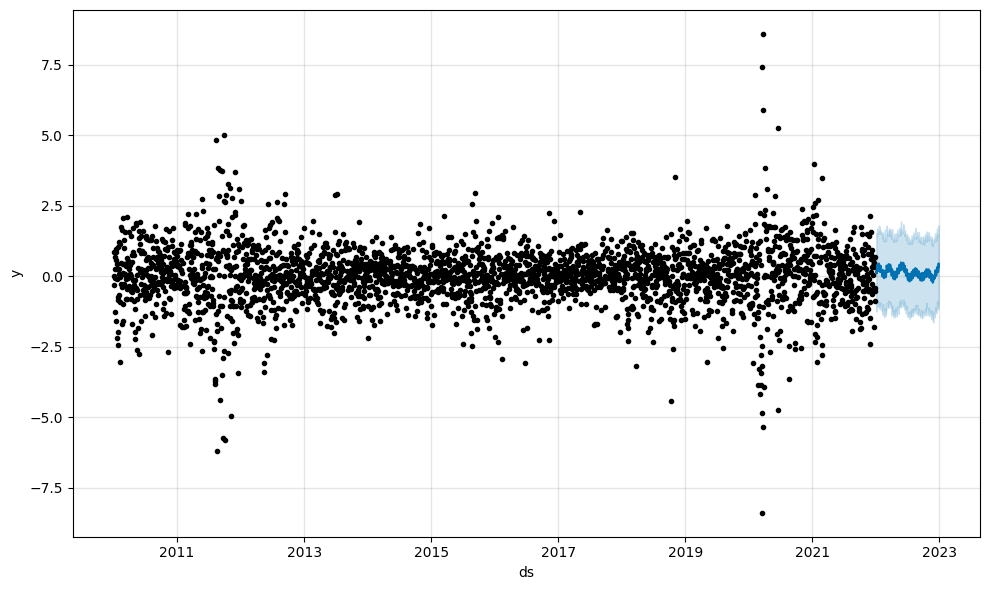

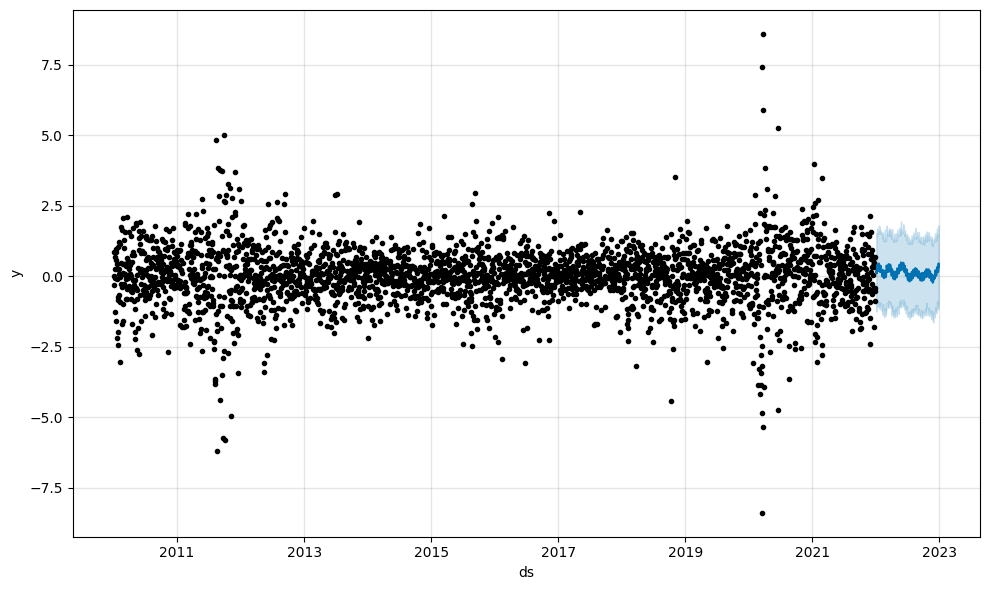

In [9]:
m = Prophet(changepoints=['2015-12-23', '2015-05-20', '2020-01-20'])

regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

for col in regressor_columns:
    m.add_regressor(col)
m.fit(train_data)

future = m.make_future_dataframe(periods=len(test_data), include_history=False)

for col in regressor_columns:
    future[col] = test_data[col].values

forecast = m.predict(future)
forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]
m.plot(forecast)

In [10]:
def train(train_data,regressors=[], **kwargs):
    
    model = Prophet(
        **kwargs,
        growth='linear',
    )
    
    columns = regressors.split('_')
    
    for col in columns:
        model.add_regressor(col)
    
    model.fit(train_data)
    train_cv = cross_validation(model, initial=f'2070 days', period='90 days', horizon='30 days', disable_tqdm=True)
    
    train_p = performance_metrics(train_cv)
    
    return model, train_cv, train_p

In [11]:
def test(model: Prophet, test_data, regressors=[], **kwargs):
    columns = regressors.split('_')
    
    # 예측 및 평가
    future = model.make_future_dataframe(periods=len(test_data), include_history=False)
    
    for col in columns:
        future[col] = test_data[col].values
    
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(test_data["y"], forecast["yhat"]))

    return rmse, forecast

In [12]:
def objective(trial: Trial) -> float:
    # 하이퍼파라미터 설정
    changepoint_prior_scale = trial.suggest_categorical("changepoint_prior_scale", [0.1, 0.2, 0.3, 0.4, 0.5])
    n_changepoints = trial.suggest_categorical("n_changepoints", [100, 150, 200])
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
    regressors = trial.suggest_categorical("regressors", regressor_combinations)

    params = {'changepoint_prior_scale': changepoint_prior_scale, 'n_changepoints': n_changepoints, 'seasonality_mode': seasonality_mode, 'regressors': regressors}
    
    _, _, train_p = train(train_data, **params)
    rmse = round(train_p["rmse"].mean(),1)
    
    return rmse

In [13]:
params_grid = {
    "changepoints": [None, ['2015-12-23', '2015-05-20', '2020-01-20']],
    "n_changepoints": [10, 20, 50],
    "seasonality_mode": ["additive", "multiplicative"],
    'seasonality_prior_scale': [5, 10, 20],
    "changepoint_prior_scale": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    # "regressors": regressor_combinations
}
grid = ParameterGrid(params_grid)

cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 324


In [14]:
regressor_combinations[-1]

'USD/KRW_GDP_IAIP_LIR_M1_disease'

In [15]:
model_parameters = []
for p in grid:
    _, _, train_p = train(train_data, regressor_combinations[-1], **p)
    rmse = round(train_p["rmse"].mean(),1)
    smape = round(train_p["smape"].mean(),1)
    p['RMSE'] = rmse
    p['SMAPE'] = smape
    p = {k: [v] for k, v in p.items()}
    model_parameters.append(pd.DataFrame(p))
model_parameters = pd.concat(model_parameters, ignore_index=True)

02:41:07 - cmdstanpy - INFO - Chain [1] start processing
02:41:07 - cmdstanpy - INFO - Chain [1] done processing
02:41:07 - cmdstanpy - INFO - Chain [1] start processing
02:41:07 - cmdstanpy - INFO - Chain [1] done processing
02:41:07 - cmdstanpy - INFO - Chain [1] start processing
02:41:08 - cmdstanpy - INFO - Chain [1] done processing
02:41:08 - cmdstanpy - INFO - Chain [1] start processing
02:41:08 - cmdstanpy - INFO - Chain [1] done processing
02:41:08 - cmdstanpy - INFO - Chain [1] start processing
02:41:08 - cmdstanpy - INFO - Chain [1] done processing
02:41:08 - cmdstanpy - INFO - Chain [1] start processing
02:41:08 - cmdstanpy - INFO - Chain [1] done processing
02:41:08 - cmdstanpy - INFO - Chain [1] start processing
02:41:08 - cmdstanpy - INFO - Chain [1] done processing
02:41:08 - cmdstanpy - INFO - Chain [1] start processing
02:41:09 - cmdstanpy - INFO - Chain [1] done processing
02:41:09 - cmdstanpy - INFO - Chain [1] start processing
02:41:09 - cmdstanpy - INFO - Chain [1]

In [16]:
model_parameters

changepoint_prior_scale                          changepoints  \
0                        0.1                                  None   
1                        0.1                                  None   
2                        0.1                                  None   
3                        0.1                                  None   
4                        0.1                                  None   
..                       ...                                   ...   
319                      0.9  [2015-12-23, 2015-05-20, 2020-01-20]   
320                      0.9  [2015-12-23, 2015-05-20, 2020-01-20]   
321                      0.9  [2015-12-23, 2015-05-20, 2020-01-20]   
322                      0.9  [2015-12-23, 2015-05-20, 2020-01-20]   
323                      0.9  [2015-12-23, 2015-05-20, 2020-01-20]   

     n_changepoints seasonality_mode  seasonality_prior_scale  RMSE  SMAPE  
0                10         additive                        5   1.2    1.6  
1                10         additive                       10   1.2    1.6  
2                10         additive                       20   1.2    1.6  
3                10   multiplicative                        5   1.2    1.7  
4                10   multiplicative                       10   1.2    1.7  
..              ...              ...                      ...   ...    ...  
319              50         additive                       10   1.2    1.5  
320              50         additive                       20   1.2    1.5  
321              50   multiplicative                        5   1.8    1.6  
322              50   multiplicative                       10   2.3    1.6  
323              50   multiplicative                       20   1.6    1.6  

[324 rows x 7 columns]

In [17]:
model_parameters_sorted = model_parameters.sort_values(by=['RMSE'], ascending=True)
min_rmse_group = model_parameters_sorted[model_parameters_sorted['RMSE'] == model_parameters_sorted['RMSE'].min()]
min_rmse_smape_group = min_rmse_group[min_rmse_group['SMAPE'] == min_rmse_group['SMAPE'].min()]
min_rmse_smape_group

changepoint_prior_scale                          changepoints  \
259                      0.8                                  None   
258                      0.8                                  None   
254                      0.8                                  None   
253                      0.8                                  None   
252                      0.8                                  None   
..                       ...                                   ...   
283                      0.8  [2015-12-23, 2015-05-20, 2020-01-20]   
204                      0.6  [2015-12-23, 2015-05-20, 2020-01-20]   
302                      0.9                                  None   
300                      0.9                                  None   
301                      0.9                                  None   

     n_changepoints seasonality_mode  seasonality_prior_scale  RMSE  SMAPE  
259              20         additive                       10   1.2    1.5  
258              20         additive                        5   1.2    1.5  
254              10         additive                       20   1.2    1.5  
253              10         additive                       10   1.2    1.5  
252              10         additive                        5   1.2    1.5  
..              ...              ...                      ...   ...    ...  
283              50         additive                       10   1.2    1.5  
204              20         additive                        5   1.2    1.5  
302              50         additive                       20   1.2    1.5  
300              50         additive                        5   1.2    1.5  
301              50         additive                       10   1.2    1.5  

[84 rows x 7 columns]

In [26]:
best_params = min_rmse_smape_group.iloc[:, :5].to_dict('records')

In [28]:
best_params

[{'changepoint_prior_scale': 0.8,
  'changepoints': None,
  'n_changepoints': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.8,
  'changepoints': None,
  'n_changepoints': 20,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.8,
  'changepoints': None,
  'n_changepoints': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.8,
  'changepoints': None,
  'n_changepoints': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.8,
  'changepoints': None,
  'n_changepoints': 10,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.7,
  'changepoints': ['2015-12-23', '2015-05-20', '2020-01-20'],
  'n_changepoints': 50,
  'seasonality_mode': 'additive',
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.7,
  'changepoints': ['2015-12-23

In [31]:
def plot_stock_forecast(data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.plot(pd.to_datetime(data['ds']), data['y'], label='Actual', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
    plt.title('Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [32]:
def printResult(test_datelist, test_true, test_forecast):
    test_result_list = []
    for date in test_datelist:
        test_result_list.append([date, test_true[date], test_forecast[date]])
    test_yyyymm = []
    test_start_y = test_result_list[0][0].year
    test_end_y = test_result_list[-1][0].year
    test_start_m = test_result_list[0][0].month
    test_end_m = test_result_list[-1][0].month
    
    if (test_start_y == test_end_y):
        for i in range(test_start_m, test_end_m + 1):
            test_yyyymm.append(test_start_y * 100 + i)
    else:
        for i in range(test_end_y - test_start_y + 1):
            if (i == 0):
                for j in range(test_start_m, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            elif (i == (test_end_y - test_start_y)):
                for j in range(1, test_end_m + 1):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            else:
                for j in range(1, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j) 
                    
    test_month_tf = {}
    errorRates = []
    for i in range(len(test_yyyymm)):
        test_month_tf[test_yyyymm[i]] = [0, 0]
    for i in range(len(test_result_list)):
        key = test_result_list[i][0].year * 100 + test_result_list[i][0].month
        test_month_tf[key][0] += test_result_list[i][1]
        test_month_tf[key][1] += test_result_list[i][2]
        
    for i in range(len(test_month_tf)):
        printYear = int(test_yyyymm[i] // 100)
        printMonth = int(test_yyyymm[i] % 100)
        printTrue = int(test_month_tf[test_yyyymm[i]][0])
        printForecast = round(test_month_tf[test_yyyymm[i]][1])
        printDiff = printTrue - printForecast
        errorRate = round(abs(printTrue - printForecast) / printTrue * 100, 2)
        print('[{0}년 {1}월] | 실제 코스피 지수: {2}원    | 예상 코스피 지수: {3}원       | 차이: {4}원       | 절대 오차율: {5}%'.format(printYear, printMonth, printTrue, printForecast, printDiff, errorRate))
        errorRates.append(errorRate)
    avg_errorRates = round(sum(errorRates)/len(errorRates), 2)
    print(f'평균 오차율: {avg_errorRates}')
    return avg_errorRates

18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing
18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1]

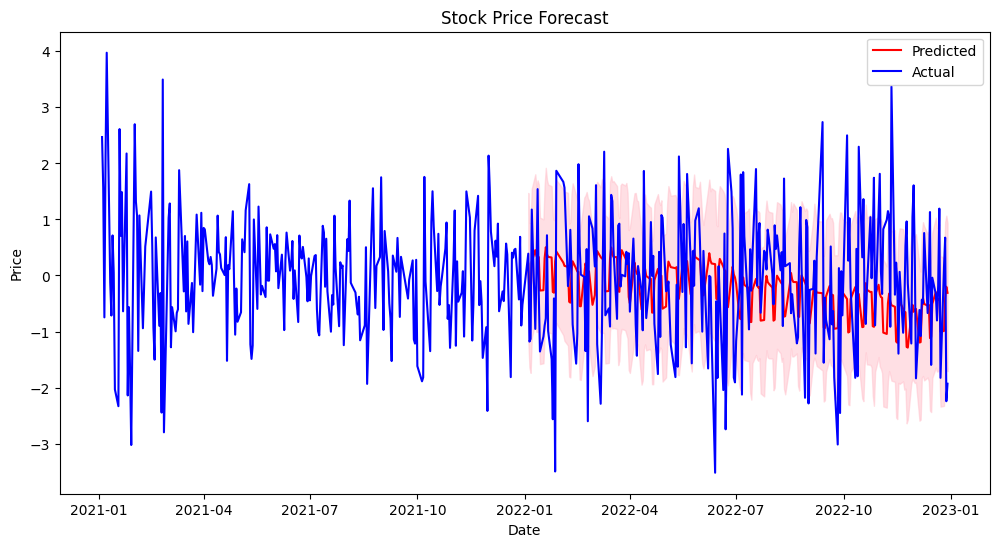

18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing
18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing
18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1]

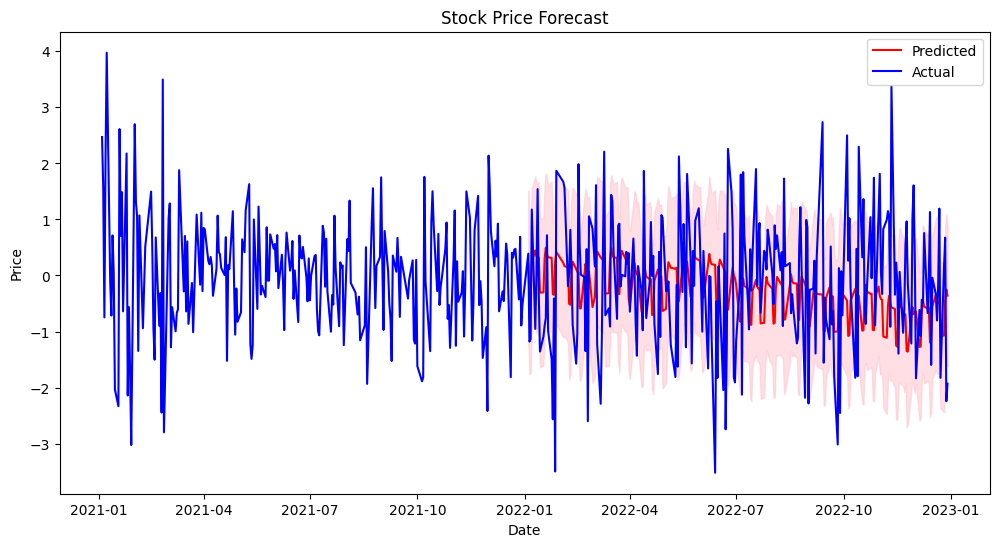

18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1]

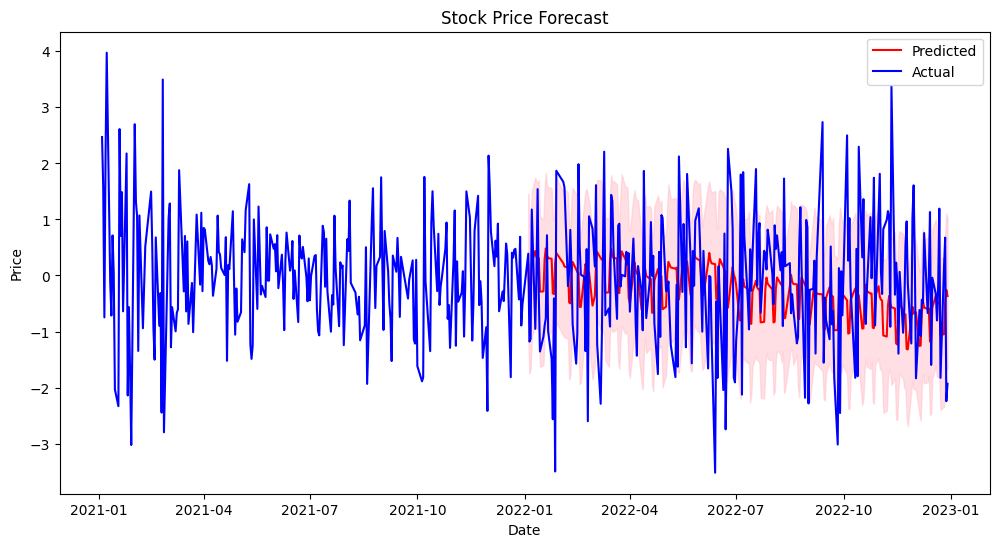

18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1]

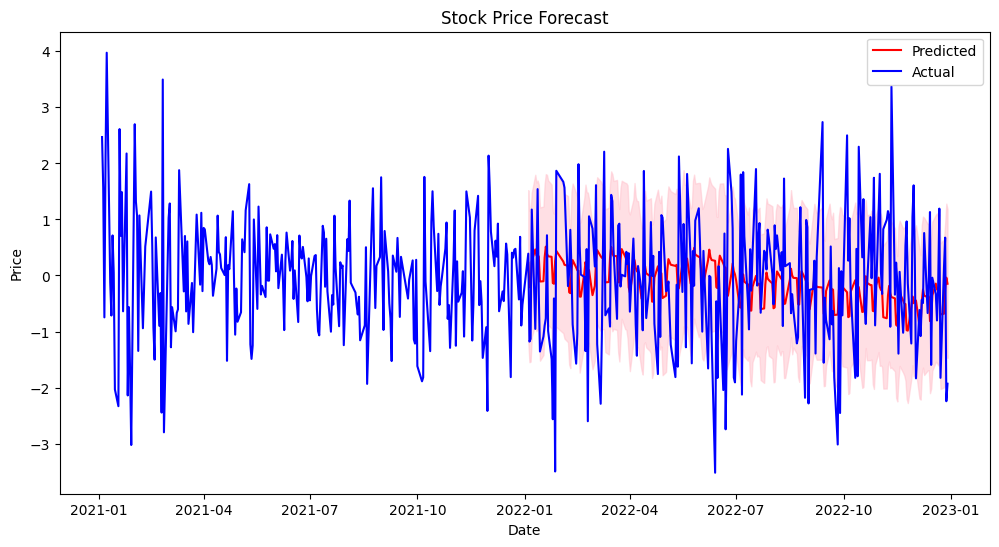

18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing
18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1]

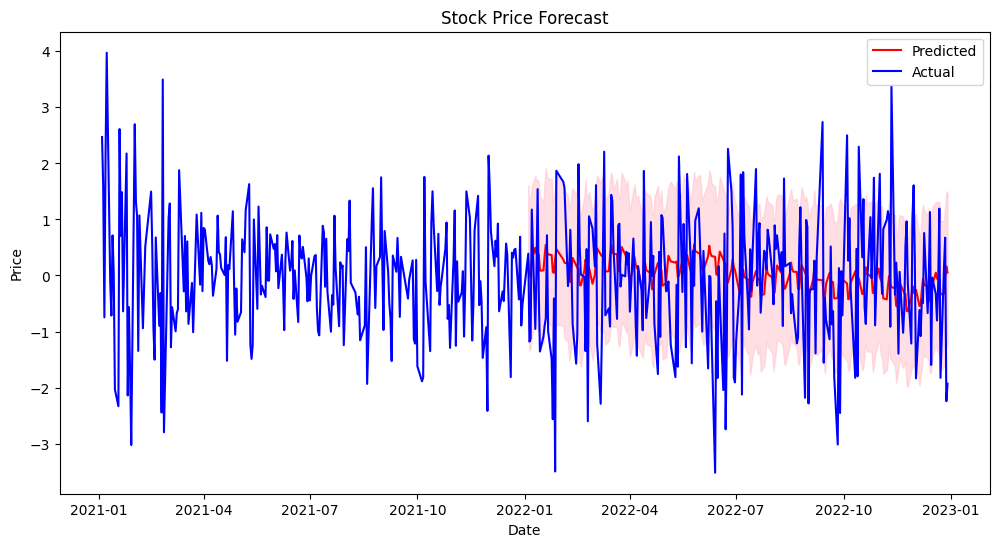

18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1]

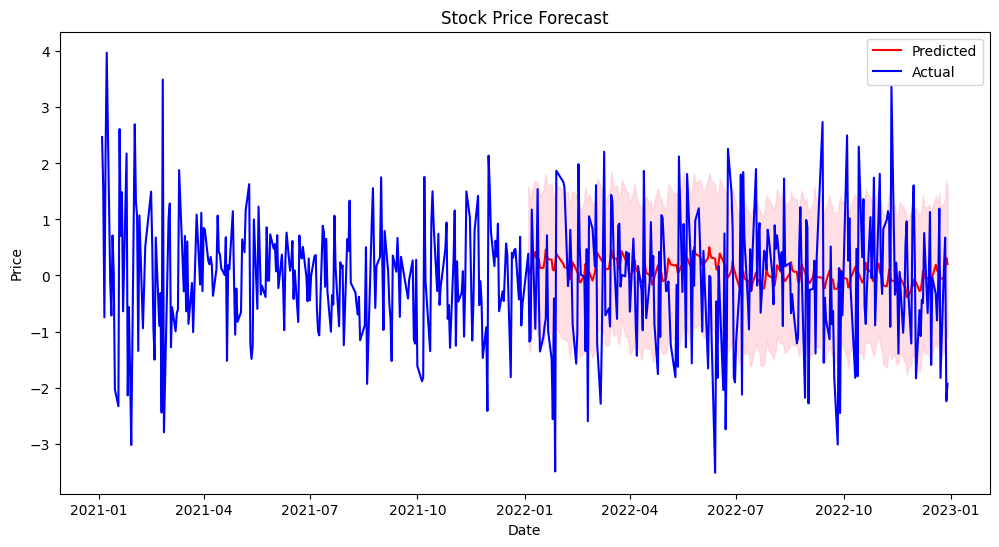

18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1]

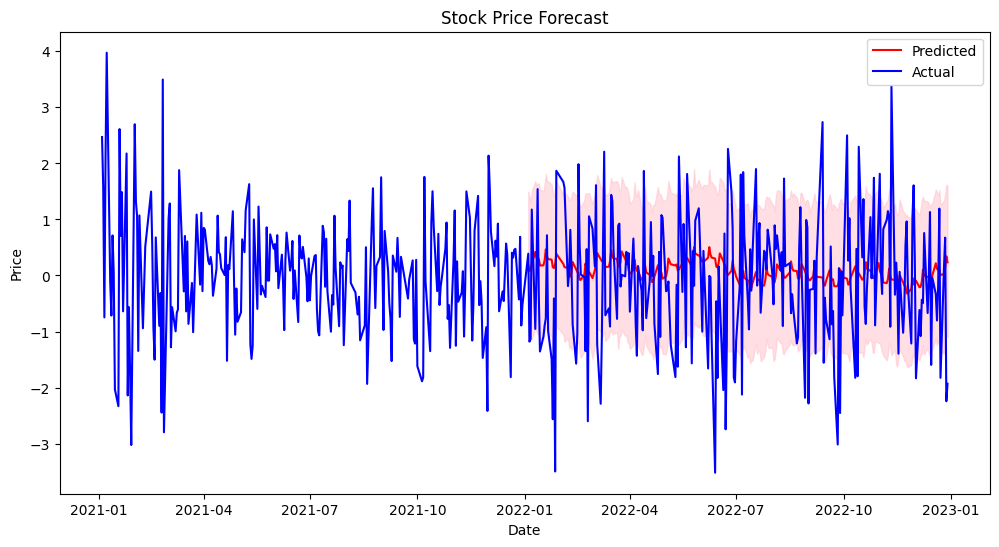

18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1] done processing
18:31:12 - cmdstanpy - INFO - Chain [1] start processing
18:31:12 - cmdstanpy - INFO - Chain [1]

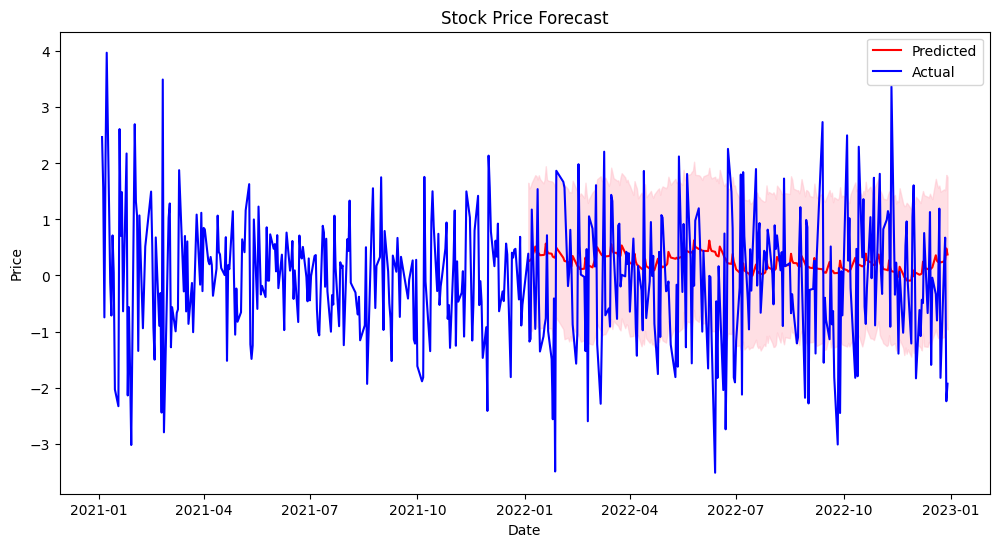

18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:21 - cmdstanpy - INFO - Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1] done processing
18:31:21 - cmdstanpy - INFO - Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1]

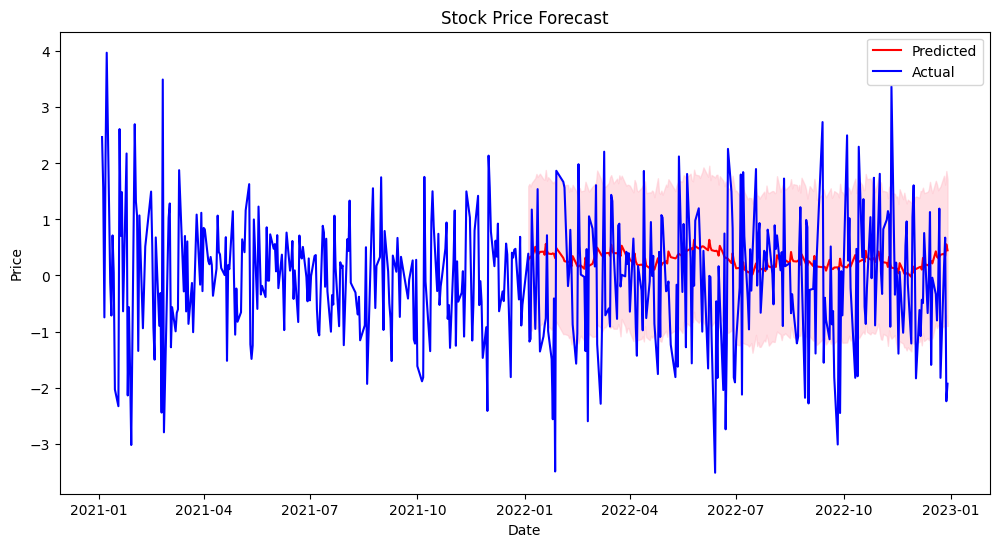

18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1]

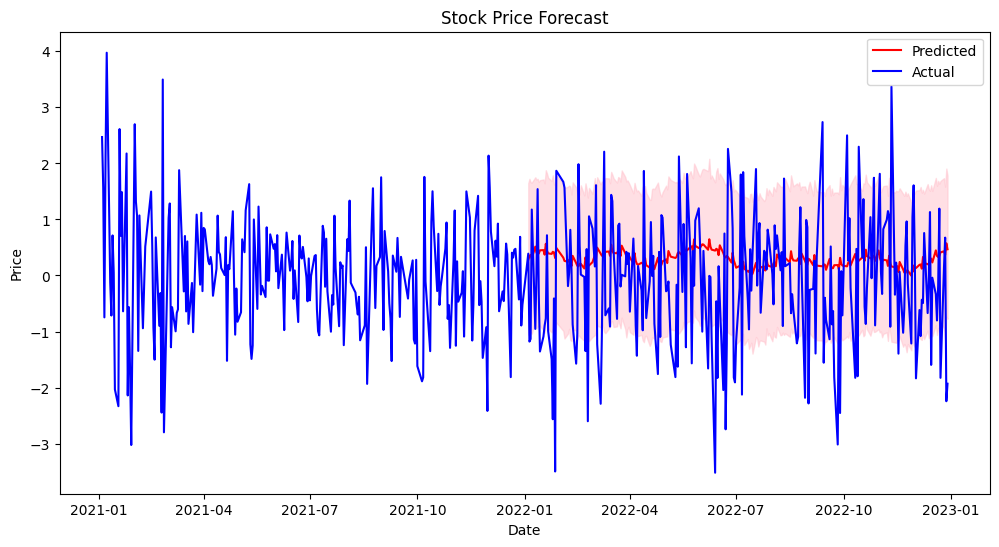

18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1]

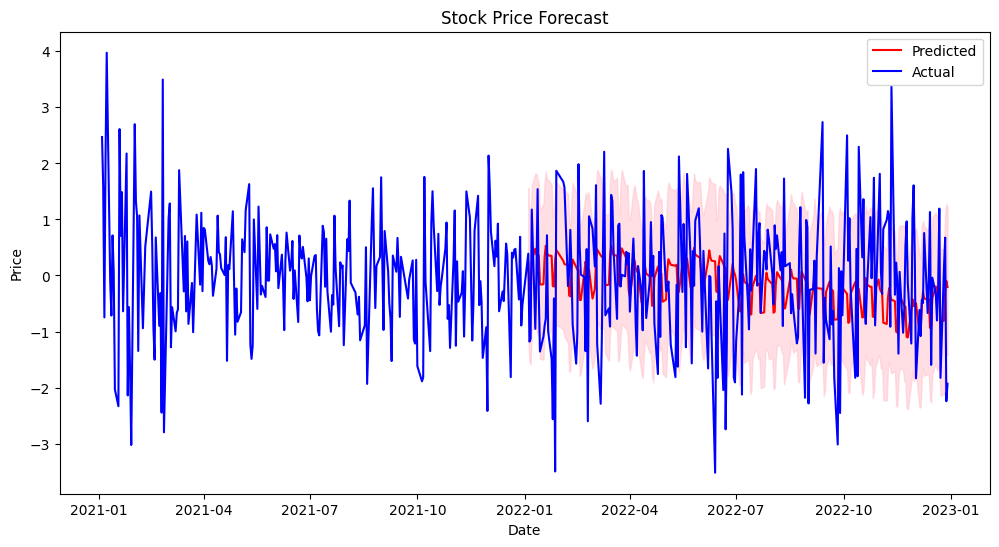

18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1]

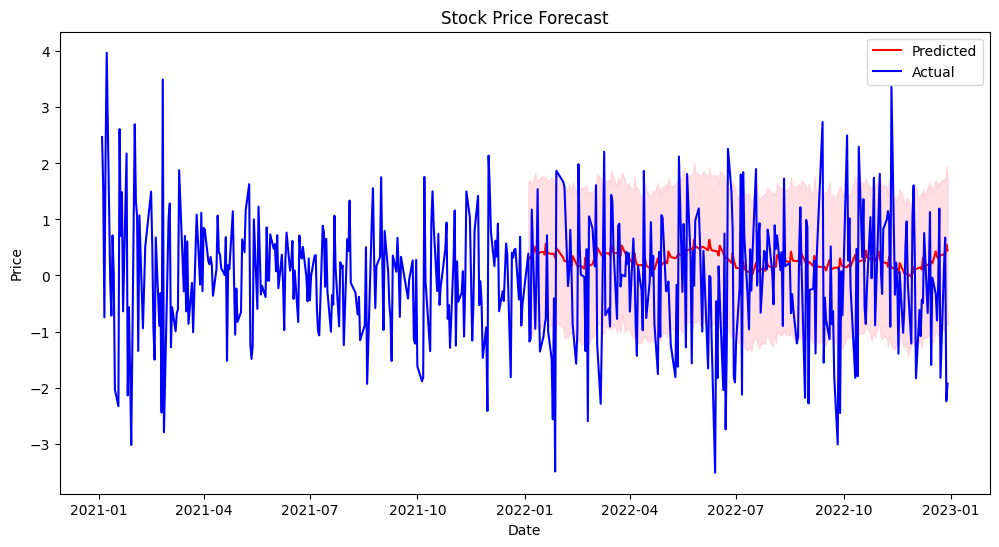

18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1]

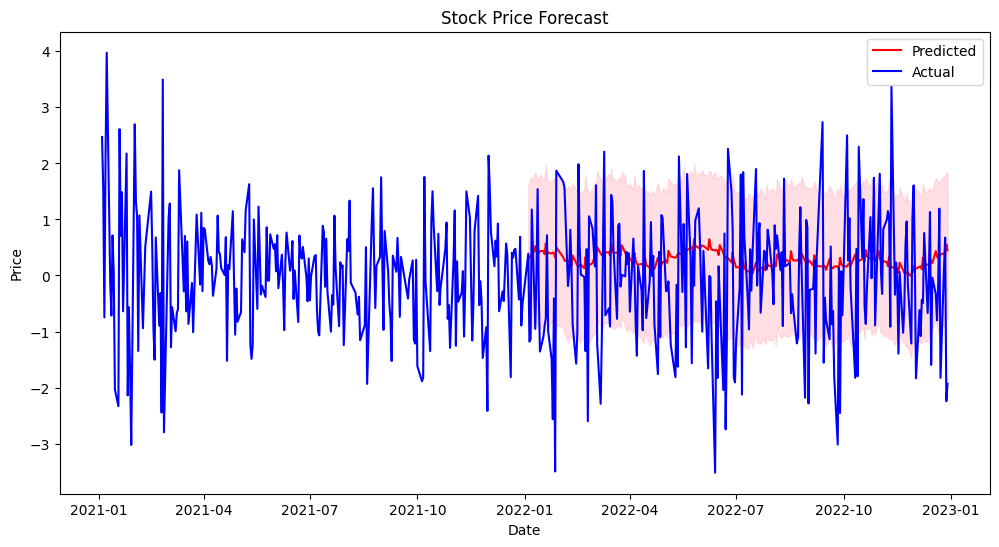

18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
18:32:17 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing
18:32:19 - cmdstanpy - INFO - Chain [1] start pro

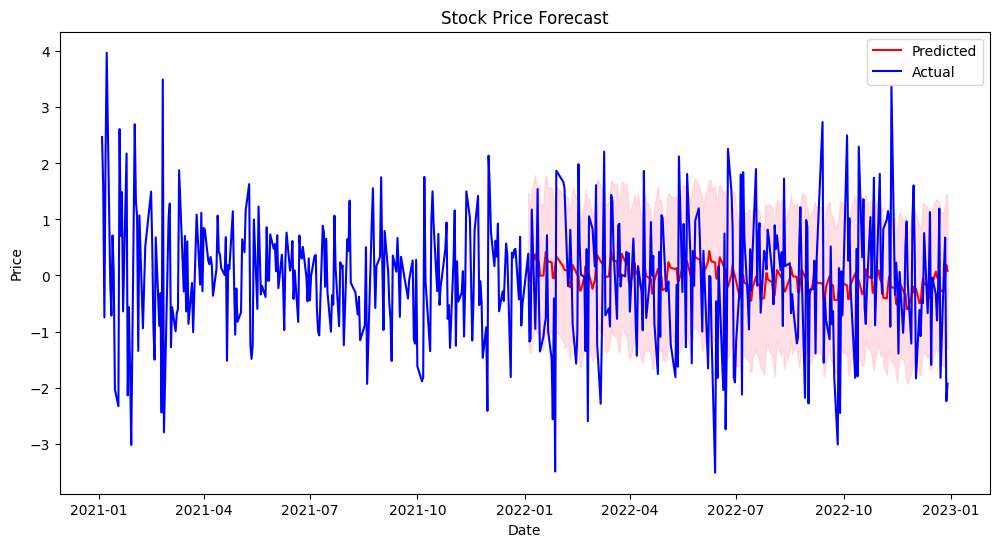

18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] start pro

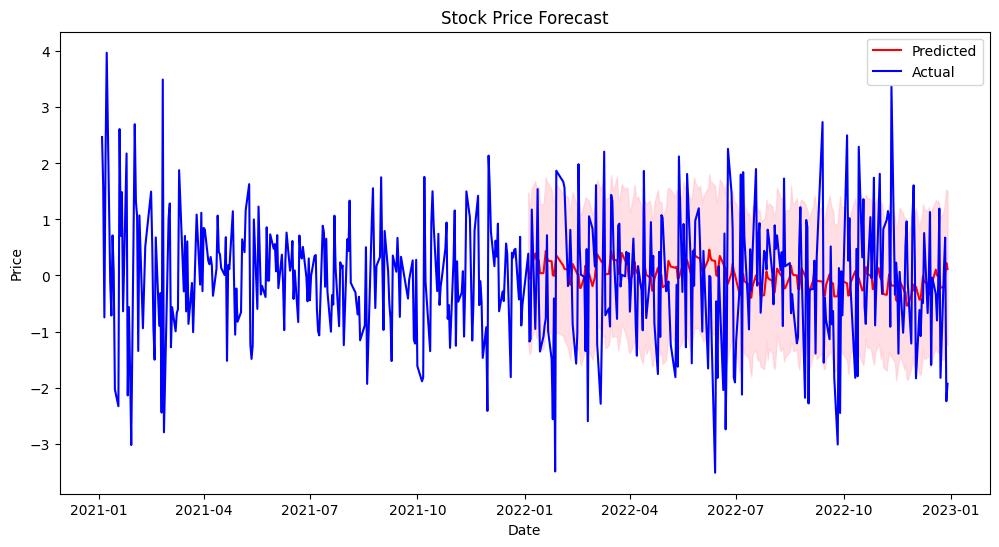

18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:43 - cmdstanpy - INFO - Chain [1] done processing
18:32:43 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1]

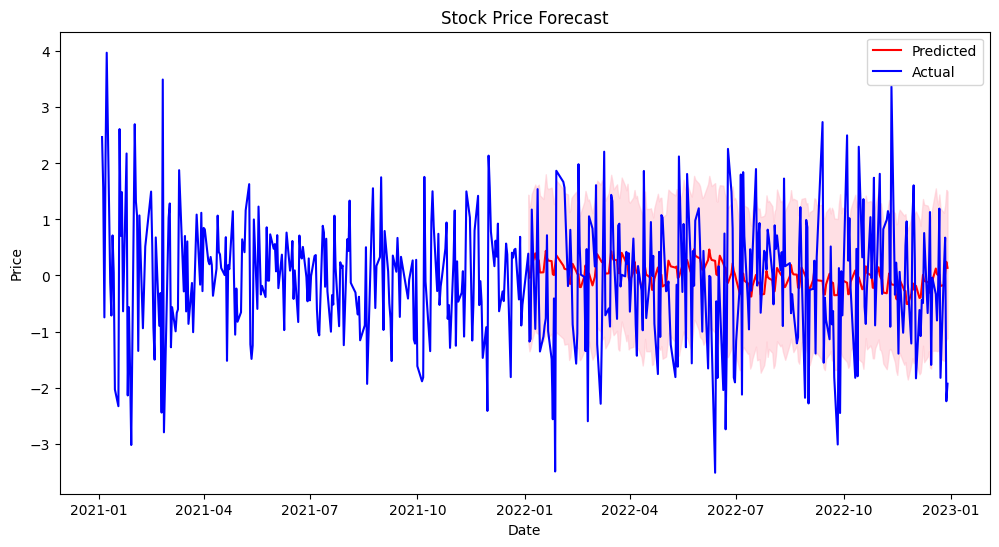

18:32:52 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start pro

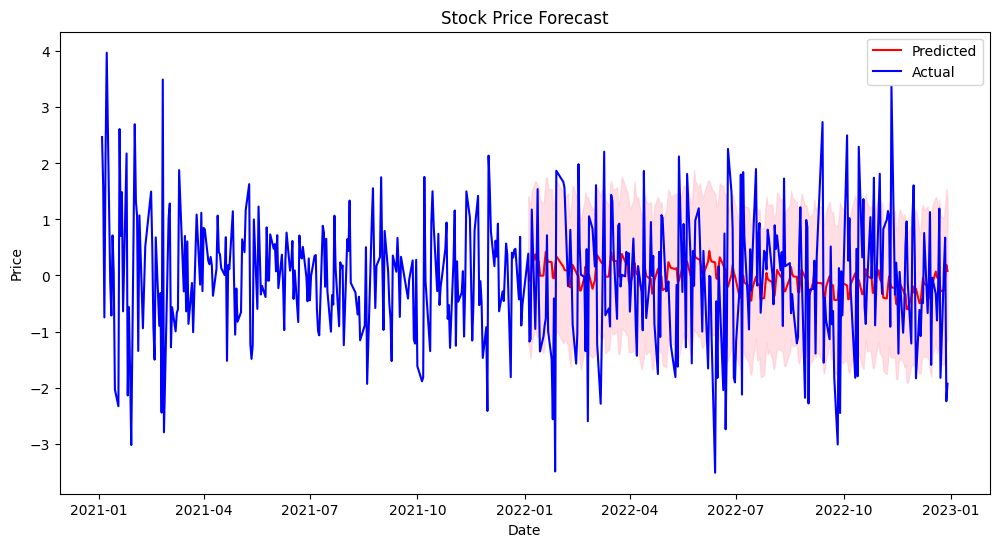

18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:09 - cmdstanpy - INFO - Chain [1] done processing
18:33:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on s

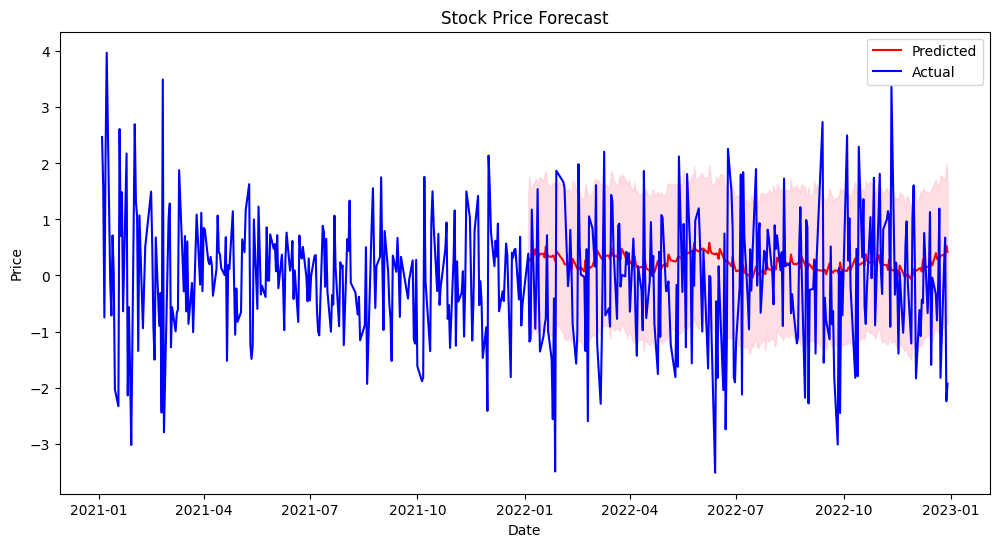

18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:22 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:23 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1]

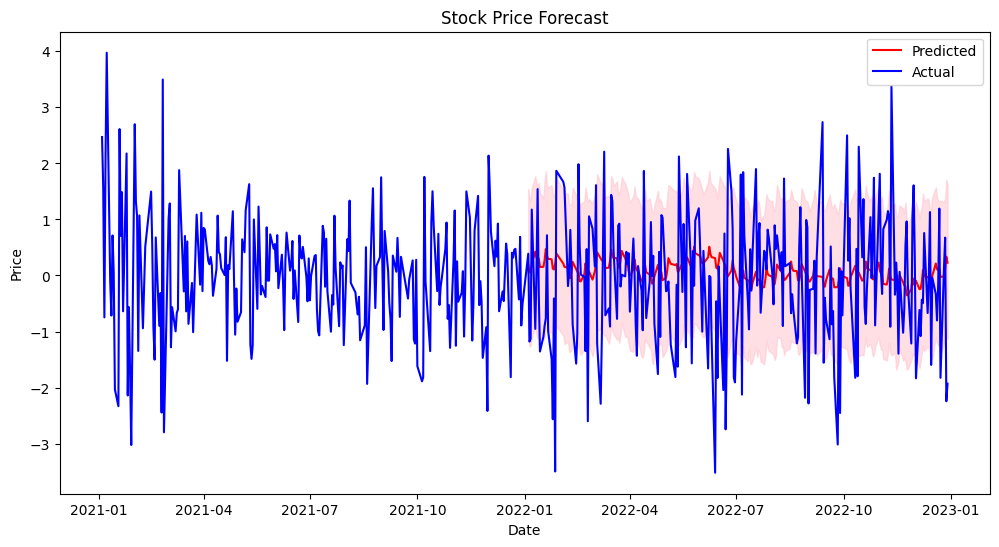

18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1] done processing
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1] done processing
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1] done processing
18:33:32 - cmdstanpy - INFO - Chain [1] start processing
18:33:32 - cmdstanpy - INFO - Chain [1] done processing
18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
18:33:33 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:34 - cmdstanpy - INFO - Chain [1] done processing
18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:34 - cmdstanpy - INFO - Chain [1]

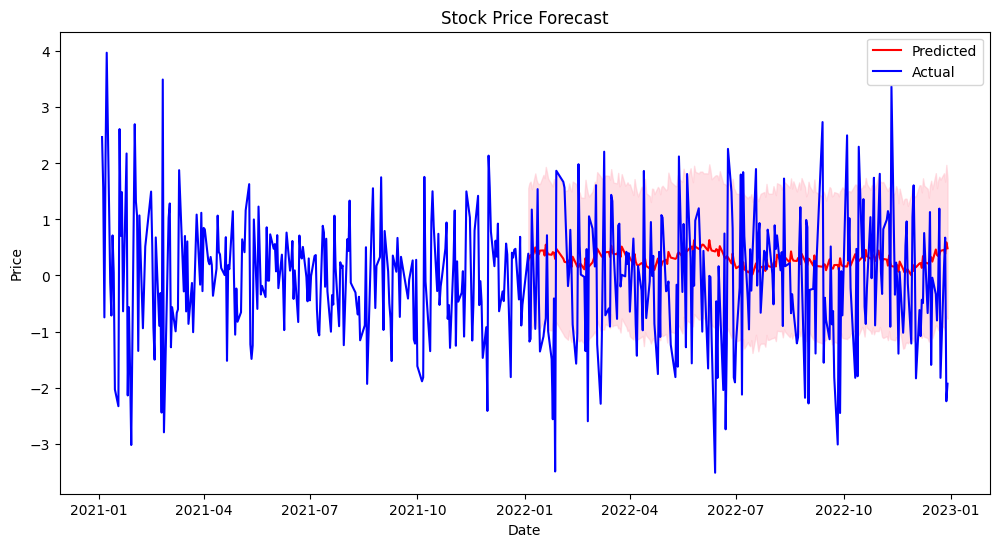

18:33:43 - cmdstanpy - INFO - Chain [1] start processing
18:33:44 - cmdstanpy - INFO - Chain [1] done processing
18:33:44 - cmdstanpy - INFO - Chain [1] start processing
18:33:45 - cmdstanpy - INFO - Chain [1] done processing
18:33:45 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1]

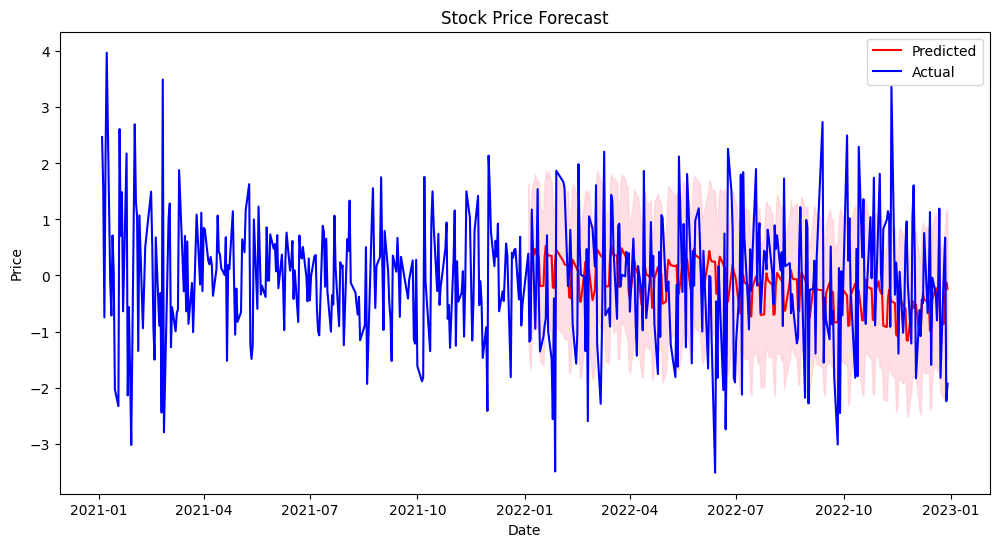

18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1] done processing
18:34:10 - cmdstanpy - INFO - Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1]

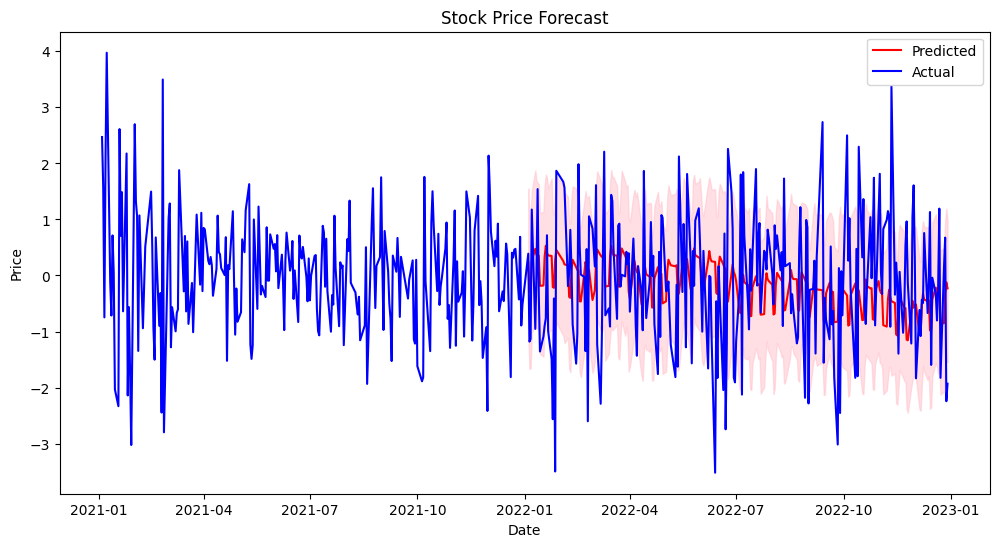

18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:28 - cmdstanpy - INFO - Chain [1] done processing
18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:28 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
18:34:29 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
18:34:30 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1]

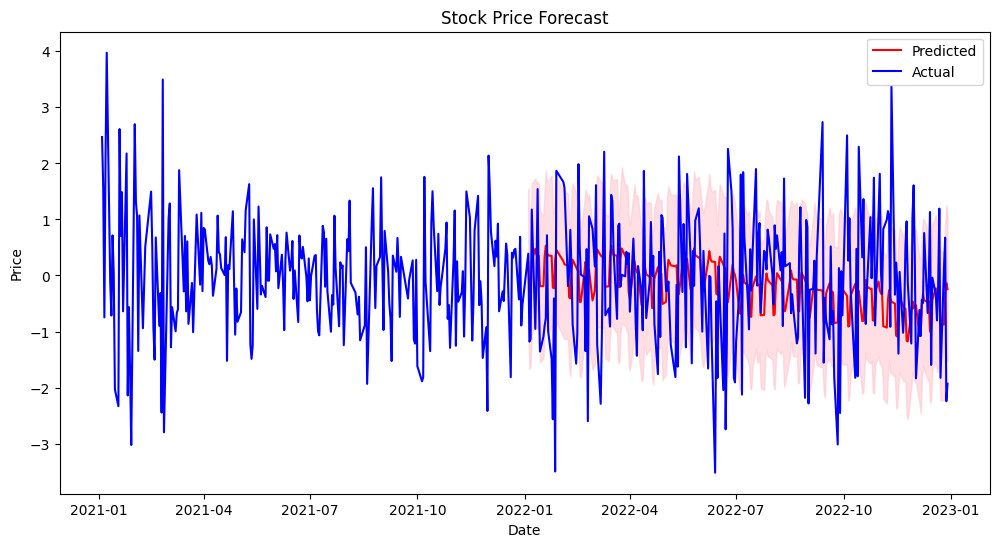

18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:50 - cmdstanpy - INFO - Chain [1] start pro

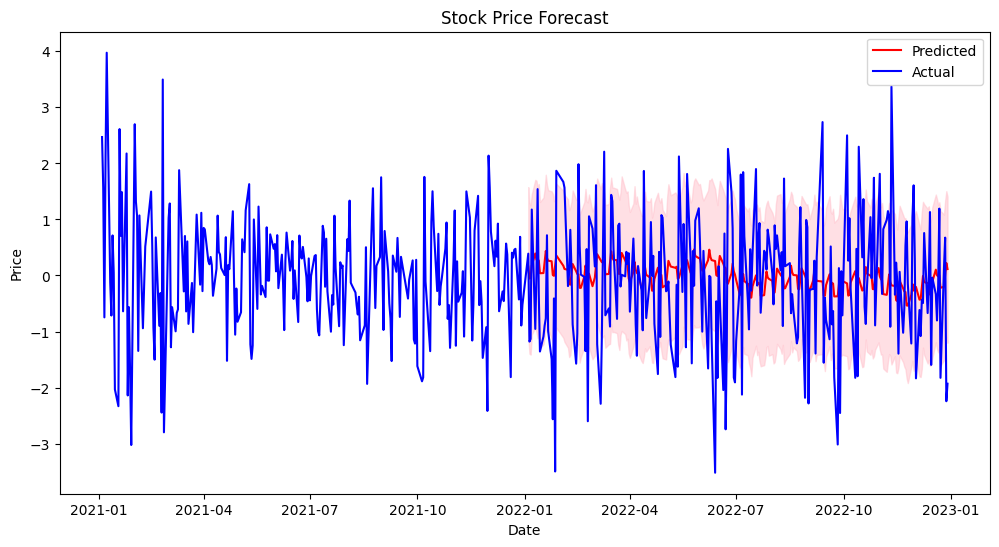

18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:34:59 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:34:59 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:34:59 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:34:59 - cmdstanpy - INFO - Chain [1] done processing
18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1]

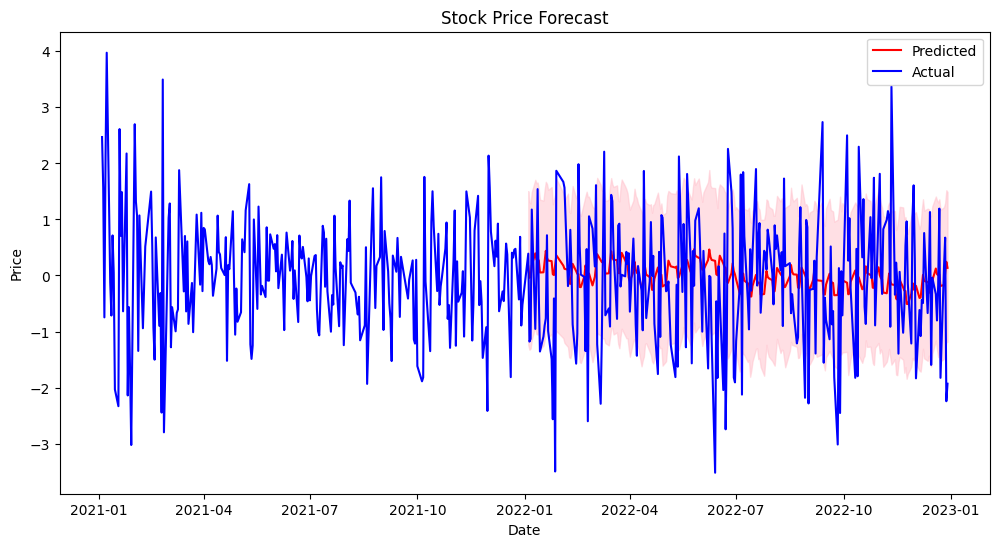

18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1]

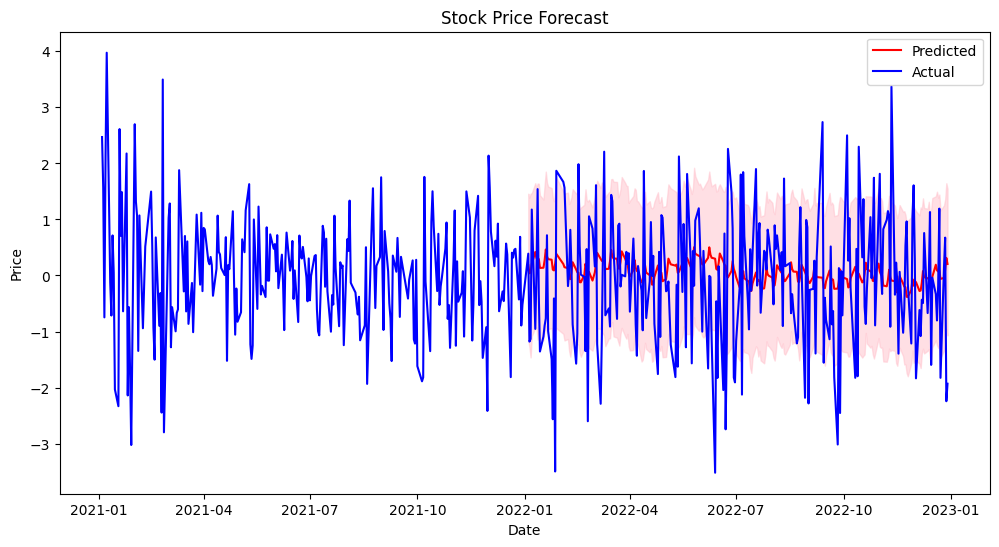

18:35:20 - cmdstanpy - INFO - Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:21 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:23 - cmdstanpy - INFO - Chain [1] done processing
18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing
18:35:24 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1]

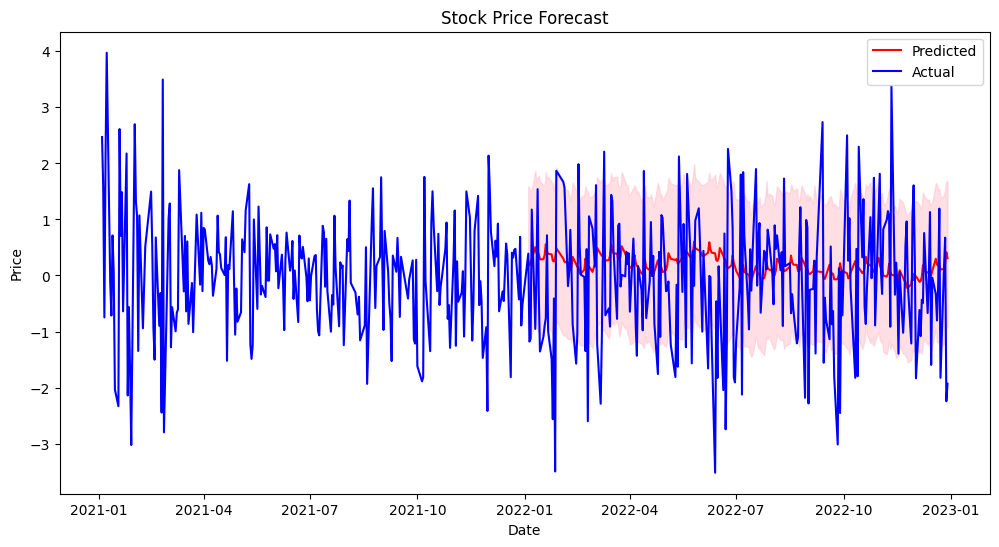

18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:37 - cmdstanpy - INFO - Chain [1]

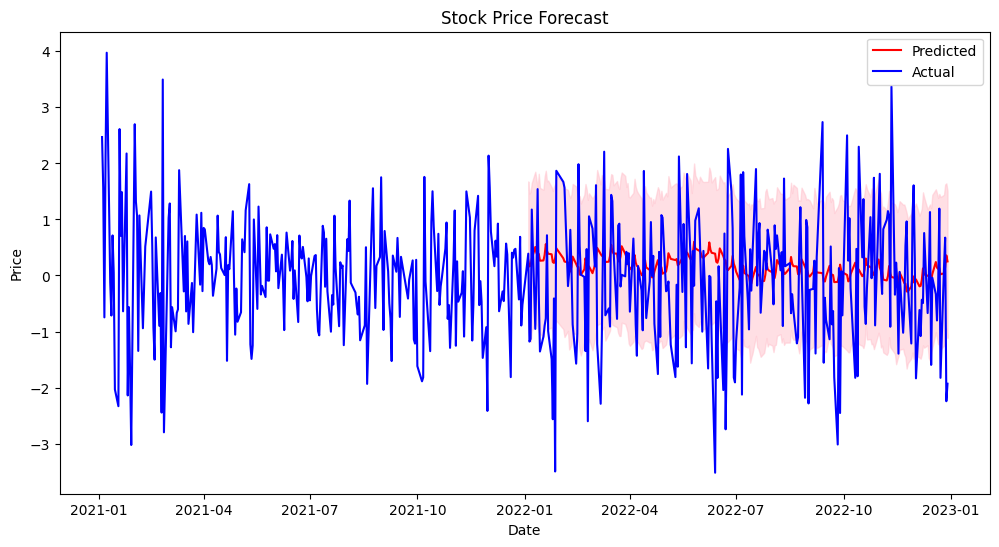

18:35:45 - cmdstanpy - INFO - Chain [1] start processing
18:35:46 - cmdstanpy - INFO - Chain [1] done processing
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:46 - cmdstanpy - INFO - Chain [1] done processing
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:46 - cmdstanpy - INFO - Chain [1] done processing
18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:47 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1]

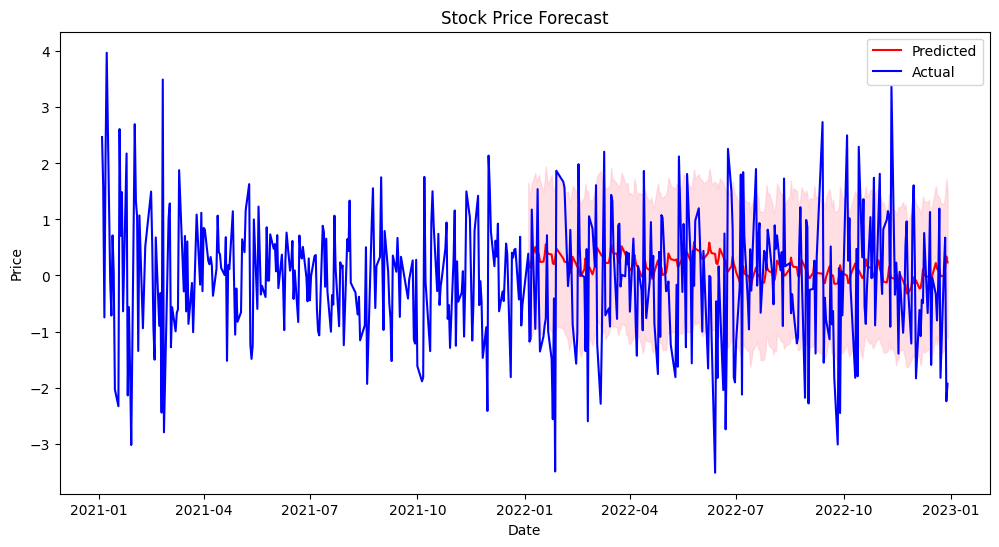

18:35:56 - cmdstanpy - INFO - Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing
18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:35:59 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1]

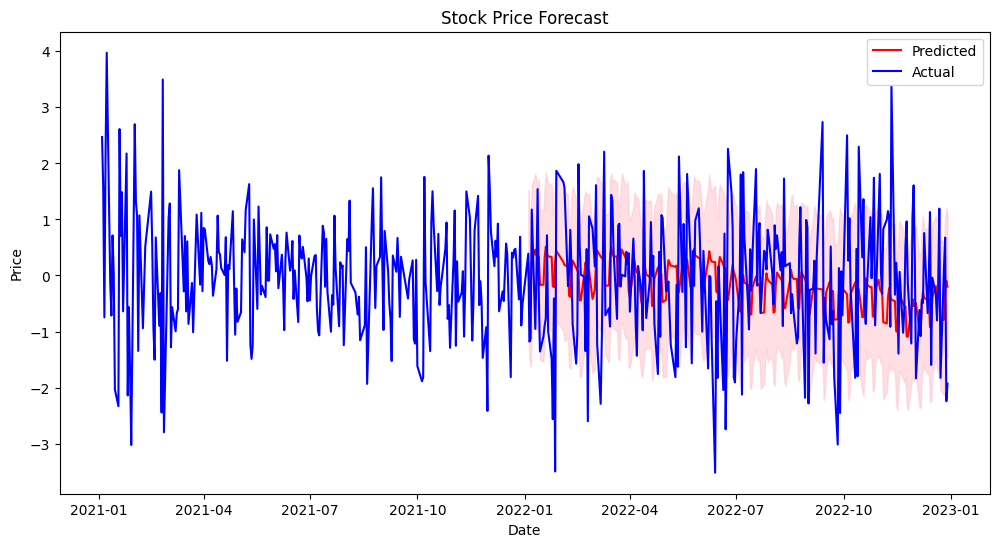

18:36:10 - cmdstanpy - INFO - Chain [1] start processing
18:36:10 - cmdstanpy - INFO - Chain [1] done processing
18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
18:36:12 - cmdstanpy - INFO - Chain [1] start processing
18:36:12 - cmdstanpy - INFO - Chain [1] done processing
18:36:12 - cmdstanpy - INFO - Chain [1] start processing
18:36:12 - cmdstanpy - INFO - Chain [1] done processing
18:36:12 - cmdstanpy - INFO - Chain [1] start processing
18:36:12 - cmdstanpy - INFO - Chain [1] done processing
18:36:13 - cmdstanpy - INFO - Chain [1] start processing
18:36:13 - cmdstanpy - INFO - Chain [1] done processing
18:36:13 - cmdstanpy - INFO - Chain [1] start processing
18:36:13 - cmdstanpy - INFO - Chain [1]

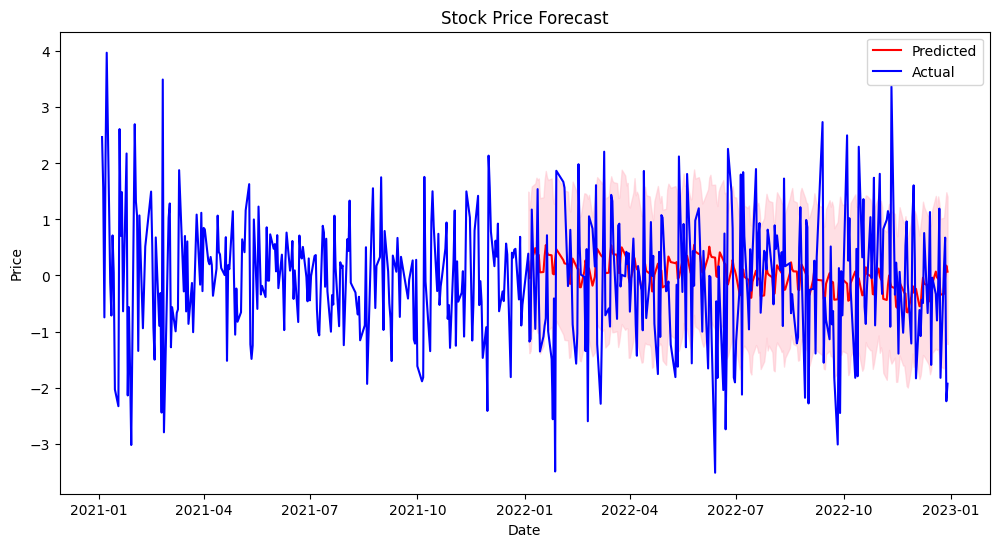

18:36:22 - cmdstanpy - INFO - Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:23 - cmdstanpy - INFO - Chain [1] done processing
18:36:23 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1]

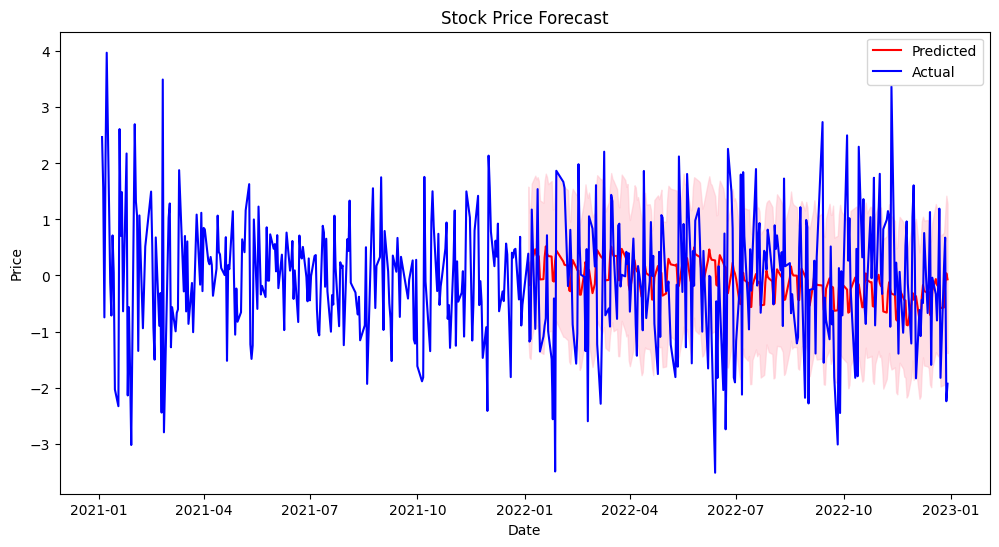

18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
18:36:37 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
18:36:37 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1]

In [34]:
for params in best_params:
    model, train_cv, train_p = train(train_data, regressor_combinations[-1], **params)
    rmse, forecast = test(model, test_data, regressor_combinations[-1], **params)
    forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]
    temp = data[data['ds'] > '2021']
    plot_stock_forecast(temp, forecast)

In [ ]:
test_datelist = test_data['ds'].to_list()
test_true = test_data.set_index('ds')['y']
test_forecast = forecast.set_index('ds')['yhat']

In [ ]:
test_true[test_datelist[0]]

In [ ]:
printResult(test_data['ds'].to_list(), test_true, test_forecast)